In [1]:
import cv2
import os
import numpy as np

DIR_DATASET_BASE = './dataset'

In [23]:
import random

import torch
from torch.nn import functional as F
from torchvision import transforms as T
from torch.utils.data import Dataset, DataLoader, random_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:", device)

def pad_to_multiple(x, multiple=16):
    """
    x: tensor de forma (B, C, H, W)
    multiple: múltiplo deseado
    """
    _, _, H, W = x.shape

    pad_h = (multiple - H % multiple) % multiple  # si ya es múltiplo queda 0
    pad_w = (multiple - W % multiple) % multiple

    # pad = (left, right, top, bottom)
    pad = (0, pad_w, 0, pad_h)
    x_padded = F.pad(x, pad)  # rellena con ceros por defecto
    return x_padded, pad_h, pad_w

class StainDataset(Dataset):
    def __init__(self, base_dir):
        self.samples = []  # lista de pares (path_corrupted, path_clean)

        # Buscar recursivamente dentro del dataset
        for batch in os.scandir(base_dir):
            if not batch.is_dir():
                continue

            for video_dir in os.scandir(batch.path):
                if not video_dir.is_dir():
                    continue

                corrupted = os.path.join(video_dir.path, "video_con_manchas.mp4")
                clean = os.path.join(video_dir.path, "video_original.mp4")

                if os.path.exists(corrupted) and os.path.exists(clean):
                    self.samples.append((corrupted, clean))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        corrupted_path, clean_path = self.samples[idx]

        # Abre videos
        cap_corr = cv2.VideoCapture(corrupted_path)
        cap_clean = cv2.VideoCapture(clean_path)

        # Elegimos un frame aleatorio
        total_frames = int(cap_corr.get(cv2.CAP_PROP_FRAME_COUNT))
        frame_idx = torch.randint(0, total_frames, (1,), generator=torch.Generator().manual_seed(42)).item()

        cap_corr.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        cap_clean.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)

        ret_corr, frame_corr = cap_corr.read()
        ret_clean, frame_clean = cap_clean.read()

        cap_corr.release()
        cap_clean.release()

        if not ret_corr or not ret_clean:
            raise RuntimeError("No se pudo leer frame")

        # Convertir a RGB y normalizar
        frame_corr = cv2.cvtColor(frame_corr, cv2.COLOR_BGR2RGB).astype("float32") / 255.0
        frame_clean = cv2.cvtColor(frame_clean, cv2.COLOR_BGR2RGB).astype("float32") / 255.0

        # (H, W, C) → (C, H, W)
        frame_corr = torch.from_numpy(frame_corr).permute(2, 0, 1)
        frame_clean = torch.from_numpy(frame_clean).permute(2, 0, 1)

            # --- Padding para múltiplo de 16 ---
        _, H, W = frame_corr.shape
        pad_h = (16 - H % 16) % 16
        pad_w = (16 - W % 16) % 16
        if pad_h > 0 or pad_w > 0:
            # (left, right, top, bottom)
            pad = (0, pad_w, 0, pad_h)
            frame_corr = F.pad(frame_corr, pad)
            frame_clean = F.pad(frame_clean, pad)

        return frame_corr, frame_clean

Usando dispositivo: cuda


In [ ]:
import time

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    # Para GPU
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # Esto elimina posibles no-determinismos de cudnn
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def train(model, optimizer, train_loader, val_loader=None, scheduler=None, epochs=100, store_every=25, patience=3, threshold=0.5):
    model = model.to(device)

    best_val_loss = float("inf")
    counter = 0

    history = {
        "train_loss": [],
        "val_loss": [],
    }

    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        time_start = time.time()
        for x, y in train_loader:
            x = x.to(device, dtype=torch.float32)
            y = y.to(device, dtype=torch.float32)

            optimizer.zero_grad()

            scores = model(x)
            loss = F.l1_loss(scores, y)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        
        avg_train_loss = total_loss / len(train_loader)

        if scheduler:
            scheduler.step()

        # Validación
        if val_loader:
            model.eval()
            val_loss = 0.0

            with torch.no_grad():
                for x_val, y_val in val_loader:
                    x_val = x_val.to(device, dtype=torch.float32)
                    y_val = y_val.to(device, dtype=torch.float32)
                    scores_val = model(x_val)
                    val_loss += F.l1_loss(scores_val, y_val).item()

            avg_val_loss = val_loss / len(val_loader)

            history["train_loss"].append(avg_train_loss)
            history["val_loss"].append(avg_val_loss)


            time_end = time.time()
            elapsed_time = time_end - time_start
            print(f"[Epoch {epoch+1}/{epochs}] [{elapsed_time:.2f}s] Train Loss={avg_train_loss:.6f} | "
                  f"Val Loss={avg_val_loss:.6f}")

            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                counter = 0
                torch.save(model.state_dict(), "best_model.pth")
            else:
                counter += 1
                if counter >= patience:
                    print(f"Early stopping en epoch {epoch+1}")
                    return model, history
        else:
            time_end = time.time()
            elapsed_time = time_end - time_start
            print(f"[Epoch {epoch+1}/{epochs}] [{elapsed_time:.2f}s] [Train] Train Loss={avg_train_loss:.6f}")

        if (epoch+1) % store_every == 0:
            torch.save(model.state_dict(), f"checkpoint_unet_{epoch+1}.pth")

    return model, history


In [25]:
set_seed(42)

dataset = StainDataset(DIR_DATASET_BASE)

BATCH_SIZE = 64
TRAIN_SIZE = int(0.8 * len(dataset))
VAL_SIZE = len(dataset) - TRAIN_SIZE

train_dataset, val_dataset = random_split(dataset, [TRAIN_SIZE, VAL_SIZE])
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)
val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=0, 
    pin_memory=True
)

In [26]:
from unet import UNet

CHANNELS_IN = 3
CHANNELS = 64

unet = UNet(CHANNELS_IN, CHANNELS).to(device)
optimizer = torch.optim.Adam(unet.parameters(), lr=1e-4)

trained_model, history = train(unet, optimizer, epochs=100, store_every=10, train_loader=train_loader, val_loader=val_loader, patience=7)

[Epoch 1/100] [328.37s] Train Loss=0.164088 | Val Loss=0.076197
[Epoch 2/100] [373.57s] Train Loss=0.069978 | Val Loss=0.041578
[Epoch 3/100] [347.02s] Train Loss=0.038379 | Val Loss=0.031509
[Epoch 4/100] [334.11s] Train Loss=0.025152 | Val Loss=0.026019
[Epoch 5/100] [374.11s] Train Loss=0.020146 | Val Loss=0.017903
[Epoch 6/100] [374.74s] Train Loss=0.017579 | Val Loss=0.015773
[Epoch 7/100] [374.92s] Train Loss=0.015971 | Val Loss=0.015974
[Epoch 8/100] [375.60s] Train Loss=0.015169 | Val Loss=0.012435
[Epoch 9/100] [373.92s] Train Loss=0.013960 | Val Loss=0.012200
[Epoch 10/100] [374.78s] Train Loss=0.013325 | Val Loss=0.011306
[Epoch 11/100] [375.37s] Train Loss=0.012483 | Val Loss=0.010919
[Epoch 12/100] [374.46s] Train Loss=0.012022 | Val Loss=0.012054
[Epoch 13/100] [374.14s] Train Loss=0.012763 | Val Loss=0.012711
[Epoch 14/100] [374.30s] Train Loss=0.012052 | Val Loss=0.011424
[Epoch 15/100] [373.72s] Train Loss=0.011079 | Val Loss=0.009350
[Epoch 16/100] [374.09s] Train Los

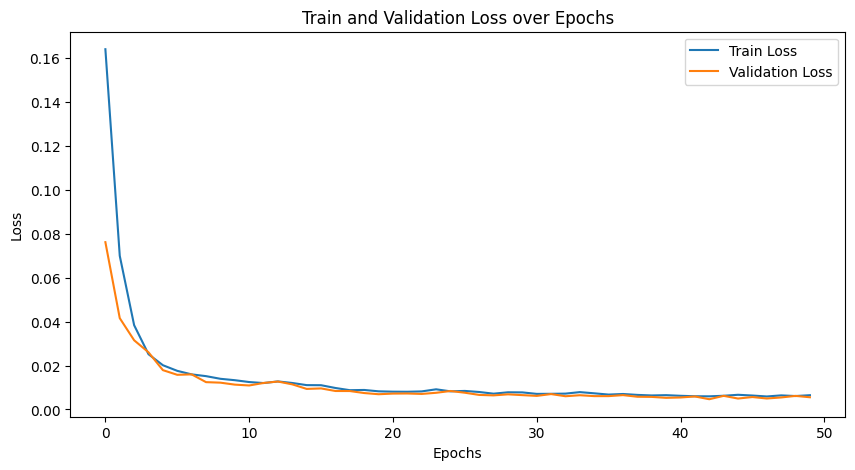

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss over Epochs')
plt.legend()
plt.show()